# Are MOFs Generated by Later Models Better?
We periodically retrain the DiffLinker, and hope that the ones generated by later interations of the model are better.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import json
import gzip

In [2]:
run_dir = Path('../../run/parallel-polaris-03Apr24153436-5d5385/')

In [23]:
Path('figures').mkdir(exist_ok=True)

## Load the Data from Disk
And make it compact


In [3]:
records = []
with gzip.open(run_dir / 'mofs.json.gz', 'rt') as fp:
    for line in tqdm(fp):
        record = json.loads(line)

        # Remove structure data, label linkers by anchor
        for k in ['md_trajectory', 'nodes', 'structure', '_id']:
            del record[k]
        for ligand in record.pop('ligands'):
            record[f'ligand.{ligand["anchor_type"]}'] = ligand
            for k in ['xyz', 'dummy_element', 'anchor_type']:
                del ligand[k]

        record['time'] = record.pop('times')['created']['$date']
        records.append(pd.json_normalize(record))
records = pd.concat(records, ignore_index=True)

532it [00:01, 271.22it/s]


Store the model versions

In [14]:
records['model_version'] = records[['ligand.cyano.metadata.model_version', 'ligand.COO.metadata.model_version']].max(axis=1)

In [4]:
records['time'] = records['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
records['walltime'] = (records['time'] - records['time'].min()).apply(lambda x: x.total_seconds())

In [32]:
records.sort_values('walltime', inplace=True)

## Plot Stability over Time
Do they get better or worse over time?

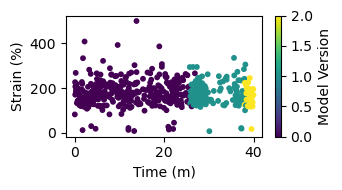

In [33]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

sc = ax.scatter(records['walltime'] / 60, records['structure_stability.uff'] * 100, s=10,
           c=records['ligand.cyano.metadata.model_version'])

fig.colorbar(sc, label='Model Version')

ax.set_xlabel('Time (m)')
ax.set_ylabel('Strain (%)')

fig.tight_layout()
fig.savefig('figures/stability-over-time.png', dpi=320)

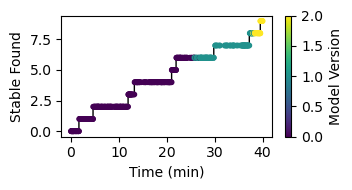

In [45]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

count = (records['structure_stability.uff'] < 0.2).cumsum()
sc = ax.scatter(
    records['walltime'] / 60, count,
    s=10, c=records['ligand.cyano.metadata.model_version']
)
ax.step(records['walltime'] / 60, count, zorder=-1, c='k', lw=1)

fig.colorbar(sc, label='Model Version')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Stable Found')

fig.tight_layout()
fig.savefig('figures/stability-over-time-step.png', dpi=320)

We don't yet see a benefit. The rate of increases don't seem to be significant.